In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import inv
from numpy import identity as I
from sklearn import datasets
from sklearn.svm import SVC, LinearSVC              # LinearSVC is faster with large datasets
from sklearn.linear_model import SGDClassifier

np.set_printoptions(sign = ' ')

In [2]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_decision_svm(X_train, y_train, clf):
    fig, ax = plt.subplots()
    X0, X1 = X_train[:, 0], X_train[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c = y_train, cmap = plt.cm.coolwarm, s = 20, edgecolors = 'k')
    plt.show()


In [3]:
def L2_dist(x1, x2):
    return np.sqrt(np.sum(np.square(x1 - x2)))

## QP Incremental SVM

In [22]:
class online_svm_qp():

    def __init__(self, threshold = None):
        
        self.bias = None
        self.weights = None
        self.X_retained = None
        self.y_retained = None

        self.support_vec_ids = None
        self.threshold = threshold
        
        self.clf = None # for plotting

        # metrics to log 
        self.min_dist_DB = 1e10
        self.min_pairwise_dist = 1e10


    def fit(self, X, y):
        """
        inputs  : X_init (numpy array)
                  y_init (numpy vector)
        outputs : None 
        """
        self.clf = SVC(kernel = 'linear')
        self.clf.fit(X, y)
        self.bias = self.clf.intercept_ 
        self.weights = self.clf.coef_
        self.support_vec_ids = set(self.clf.support_)
        self.update_candidates(X, y)
        

    def distance_DB(self, x, y):
        """
        inputs  : x (numpy vector)
                  y (int: 1 or -1)
        outputs : distance to hyperplane
        """
        assert (y == -1) or (y == 1) # should not pass 0
        fx = np.dot(self.weights, x)[0] + self.bias[0]
        return y * (fx) / np.linalg.norm(self.weights)


    def update_candidates(self, X, y):
        """
        inputs  : X (numpy array)
                  y (numpy vector)
        outputs : None
        """
        # centroids
        pos_centroid = np.mean(X[np.where(y == 1)], axis = 0)
        neg_centroid = np.mean(X[np.where(y == 0)], axis = 0)

        # distance to closest svec
        R_pos = R_neg = 1e10
        for i in self.support_vec_ids: 
            
            pos_dist = L2_dist(pos_centroid, X[i])
            neg_dist = L2_dist(neg_centroid, X[i])

            R_pos = min(pos_dist, R_pos)
            R_neg = min(neg_dist, R_neg)

        # centoids to hyperplane distances
        R0_pos = self.distance_DB(pos_centroid, 1)
        R0_neg = self.distance_DB(neg_centroid, -1)

        # logging min_pairwise_dist (only searching among svecs)
        svec_ids_array = np.array(list(self.support_vec_ids))
        X_svecs_pos = X[svec_ids_array, :][y[svec_ids_array] == 1]
        X_svecs_neg = X[svec_ids_array, :][y[svec_ids_array] == 0]

        self.min_pairwise_dist = 1e5
        for x_pos in X_svecs_pos:
            for x_neg in X_svecs_neg:
                self.min_pairwise_dist = min(self.min_pairwise_dist, L2_dist(x_pos, x_neg))

        # selecting CSVs
        self.X_retained = []
        self.y_retained = []
        for i in range(X.shape[0]):

            if i in self.support_vec_ids: 
                self.X_retained.append(X[i])
                self.y_retained.append(y[i])

                # logging min_dist TO TRUTH (only need searching among support vecs)
                # self.min_dist_DB = min(self.min_dist_DB, CALL TRUE DB DISTANCE FUNCTION)

            else:
                if y[i] == 1:
                    d = L2_dist(X[i], pos_centroid)
                else:
                    d = L2_dist(X[i], neg_centroid)                

                if not isinstance(self.threshold, float):
                    if y[i] == 1:
                        if (d >= R_pos) and (self.distance_DB(X[i], 1) <= R0_pos):
                            self.X_retained.append(X[i])
                            self.y_retained.append(y[i])
                    else:
                        if (d >= R_neg) and (self.distance_DB(X[i], -1) <= R0_neg):
                            self.X_retained.append(X[i])
                            self.y_retained.append(y[i])

                else:                     
                    
                    L = 1 / np.linalg.norm(self.weights) # 1/2 margin distance
                    
                    if y[i] == 1:
                        t = d / (d + R_pos) + L / (L + self.distance_DB(X[i], 1)) - 1
                        if -self.threshold < t < self.threshold:
                            self.X_retained.append(X[i])
                            self.y_retained.append(y[i])
                    else:
                        t = d / (d + R_neg) + L / (L + self.distance_DB(X[i], -1)) - 1
                        if -self.threshold < t < self.threshold:
                            self.X_retained.append(X[i])
                            self.y_retained.append(y[i])
      
        self.X_retained = np.array(self.X_retained)
        self.y_retained = np.array(self.y_retained)

    def update(self, X, y, tol = 1e-3):

        if X.ndim == 1:
            X = np.expand_dims(X, axis = 0)
            y = np.expand_dims(y, axis = 0)

        X_violations = []
        y_violations = []
        for i in range(X.shape[0]):
            if y[i] == 1:
                if (self.distance_DB(X[i], 1) < 1 - tol):
                    X_violations.append(X[i])
                    y_violations.append(y[i])

            else:
                if (self.distance_DB(X[i], -1) < 1 - tol):
                    X_violations.append(X[i])
                    y_violations.append(y[i])

        if X_violations == []:
            return 

        else:

            # TODO: CHECK FOR FIT VS PARTIAL FIT  (OPTIONAL) 

            self.X_retained = np.vstack((self.X_retained, X_violations))
            self.y_retained = np.append(self.y_retained, y_violations)

            self.fit(self.X_retained, self.y_retained)



## Least Squares Incremental SVM

In [26]:

class online_lssvm():

    def __init__(self, rho = 0.001):
        
        self.C = None
        self.rho = rho
        self.weights = None

    def fit(self, X, y):

        y[y == 0] = -1 # labels must be -1 or 1
        X = np.c_[np.ones((X.shape[0], 1)), X] # appending 1s

        self.C = X.T @ inv(X @ X.T + self.rho * I(X.shape[0])) @ X # p X p
        self.weights = (inv(X.T @ X + self.rho * I(X.shape[1])) @ X.T) @ y 
    
    def update(self, X, y):

        if X.ndim == 1:
            X = np.expand_dims(X, axis = 0)
            y = np.expand_dims(y, axis = 0)

        r = self.rho
        N = X.shape[0]
        p = self.C.shape[0]
        y[y == 0] = -1 # labels must be -1 or 1

        X = np.c_[np.ones((X.shape[0], 1)), X]
        self.C += (self.C - I(p)) @ X.T @ inv(r * I(N) - X @ (self.C - I(p)) @ X.T) @ X @ (self.C - I(p))
        self.weights += (self.C - I(p)) @ X.T @ inv(r * I(N) - X @ (self.C - I(p)) @ X.T) @ (X @ self.weights - y)

    def predict(self, X):
        
        X = np.c_[np.ones((X.shape[0], 1)), X]
        return np.where(X @ self.weights >= 0, 1, 0)



## Updating piece by piece

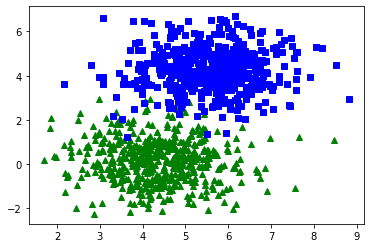

In [6]:
X, y = datasets.make_blobs(n_samples = 1000, centers = 2, n_features = 2, center_box = (0, 10), random_state = 2)
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'g^')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs')
plt.show()

In [7]:
X_init, y_init = X[:500, :], y[:500]
X_u1, y_u1 = X[500:700, :], y[500: 700]
X_u2, y_u2 = X[700:, :], y[700:]

In [8]:
# testing for weird patterns of updates
# X_init, y_init = X[X[:, 0] > 5.5, :], y[X[:, 0] > 5.5]
# X_u1, y_u1 = X[(X[:, 0] < 5.5) & (X[:, 0] > 4), :], y[(X[:, 0] < 5.5) & (X[:, 0] > 4)]
# X_u2, y_u2 = X[X[:, 0] < 4, :], y[X[:, 0] < 4]

In [12]:
qp_svm = online_svm_qp()
s = time.time()
qp_svm.fit(X_init, y_init)
print('qp_svm     :', time.time() - s)

X_a, y_a = X_init, y_init
ridge_svm = online_lssvm(1e-6) # svm based on ridge regression
s = time.time()
ridge_svm.fit(X_a, y_a.copy())
print('ridge svm  :', time.time() - s)

attacker = SVC(kernel = 'linear')
s = time.time()
attacker.fit(X_a, y_a)
print('attacker   :', time.time() - s, end = "\n\n")

print('qp svm     : weights = ', np.round(qp_svm.weights[0], 4), '; bias = ', np.round(qp_svm.bias[0], 4))
print('attacker   : weights = ', np.round(attacker.coef_[0], 4), '; bias = ', np.round(attacker.intercept_[0], 4))
print('ridge svm  : weights = ', np.round(ridge_svm.weights[1:], 4), '; bias = ', np.round(ridge_svm.weights[0], 4))

qp_svm     : 0.005984306335449219
ridge svm  : 0.019004106521606445
attacker   : 0.0010001659393310547

qp svm     : weights =  [-0.3203  1.7461] ; bias =  -0.8565
attacker   : weights =  [-0.3203  1.7461] ; bias =  -0.8565
ridge svm  : weights =  [ 0.0167  0.336 ] ; bias =  -0.6308


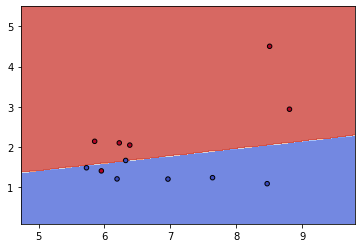

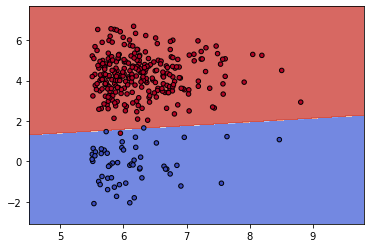

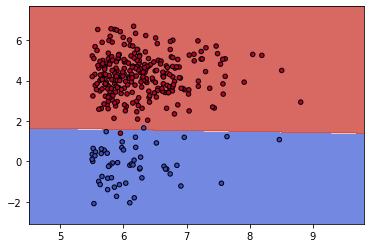

In [13]:
plot_decision_svm(qp_svm.X_retained, qp_svm.y_retained, qp_svm.clf)
plot_decision_svm(X_a, y_a, attacker)
plot_decision_svm(X_a, y_a, ridge_svm)

In [14]:
s = time.time()
qp_svm.update(X_u1, y_u1)
print('qp_svm     :', time.time() - s)

s = time.time()
ridge_svm.update(X_u1, y_u1.copy())
print('ridge svm  :', time.time() - s)

X_a = np.vstack((X_a, X_u1))
y_a = np.append(y_a, y_u1)

s = time.time()
attacker.fit(X_a, y_a)
print('attacker   :', time.time() - s, end = "\n\n")

print('qp svm     : weights = ', np.round(qp_svm.weights[0], 4), '; bias = ', np.round(qp_svm.bias[0], 4))
print('attacker   : weights = ', np.round(attacker.coef_[0], 4), '; bias = ', np.round(attacker.intercept_[0], 4))
print('ridge svm  : weights = ', np.round(ridge_svm.weights[1:], 4), '; bias = ', np.round(ridge_svm.weights[0], 4))

qp_svm     : 0.007993698120117188
ridge svm  : 0.03000783920288086
attacker   : 0.0009999275207519531

qp svm     : weights =  [ 0.2848  0.4715] ; bias =  -3.5464
attacker   : weights =  [ 0.4477  2.125 ] ; bias =  -7.0098
ridge svm  : weights =  [ 0.0348  0.3644] ; bias =  -0.8981


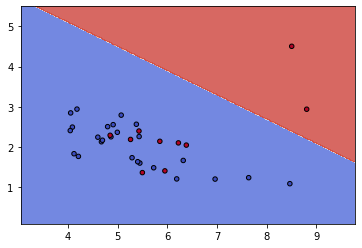

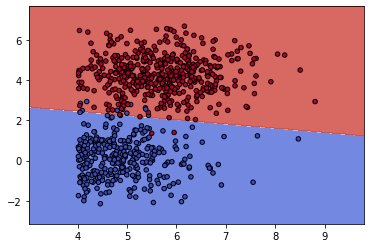

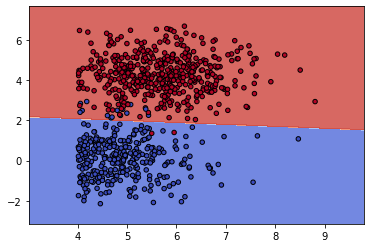

In [15]:
plot_decision_svm(qp_svm.X_retained, qp_svm.y_retained, qp_svm.clf)
plot_decision_svm(X_a, y_a, attacker)
plot_decision_svm(X_a, y_a, ridge_svm)

In [16]:
s = time.time()
qp_svm.update(X_u2, y_u2)
print('qp_svm     :', time.time() - s)

s = time.time()
ridge_svm.update(X_u2, y_u2.copy())
print('ridge svm  :', time.time() - s)

X_a = np.vstack((X_a, X_u2))
y_a = np.append(y_a, y_u2)

s = time.time()
attacker.fit(X_a, y_a)
print('attacker   :', time.time() - s, end = "\n\n")

print('qp svm     : weights = ', np.round(qp_svm.weights[0], 4), '; bias = ', np.round(qp_svm.bias[0], 4))
print('attacker   : weights = ', np.round(attacker.coef_[0], 4), '; bias = ', np.round(attacker.intercept_[0], 4))
print('ridge svm  : weights = ', np.round(ridge_svm.weights[1:], 4), '; bias = ', np.round(ridge_svm.weights[0], 4))

qp_svm     : 0.0080108642578125
ridge svm  : 0.003992319107055664
attacker   : 0.001997232437133789

qp svm     : weights =  [ 0.1263  1.2066] ; bias =  -3.6559
attacker   : weights =  [ 0.4579  1.9259] ; bias =  -6.5835
ridge svm  : weights =  [ 0.0929  0.359 ] ; bias =  -1.1767


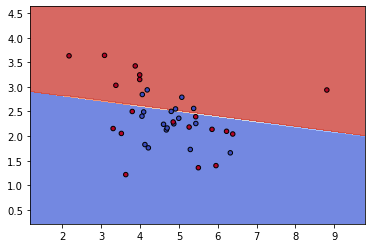

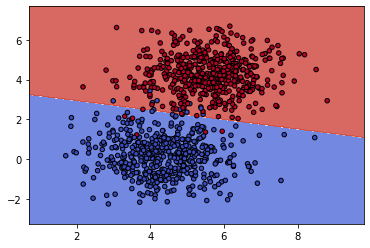

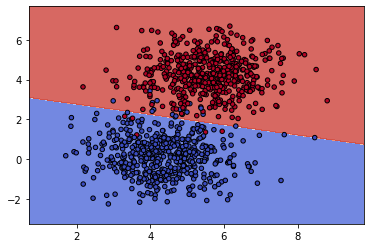

In [17]:
plot_decision_svm(qp_svm.X_retained, qp_svm.y_retained, qp_svm.clf)
plot_decision_svm(X_a, y_a, attacker)
plot_decision_svm(X_a, y_a, ridge_svm)

In [18]:
from pympler import asizeof
print('qp_svm    : ', str(asizeof.asizeof(qp_svm) / 1e6) + ' mb')
print('ridge_svm : ', str(asizeof.asizeof(ridge_svm) / 1e6) + ' mb') 

qp_svm    :  0.010832 mb
ridge_svm :  0.000664 mb


In [19]:
from sklearn.metrics import accuracy_score
print(f'qp_svm    : ', accuracy_score(qp_svm.clf.predict(X_a), y_a))
print(f'ridge svm : ', accuracy_score(ridge_svm.predict(X_a), y_a))
print(f'attacker  : ', accuracy_score(attacker.predict(X_a), y_a))

qp_svm    :  0.979
ridge svm :  0.978
attacker  :  0.983


## Testing point by point

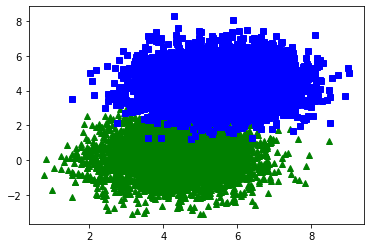

In [35]:
X, y = datasets.make_blobs(n_samples = 10000, centers = 2, n_features = 2, center_box = (0, 10), random_state = 2)
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'g^')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs')
plt.show()

In [43]:
qp_svm = online_svm_qp()
s = time.time()
X_init, y_init = X[:5, :], y[:5] # must have both classes in y_init
qp_svm.fit(X_init, y_init) 

for i in range(100, 10000):
    qp_svm.update(X[i, :], y[i])

print('qp_svm     :', time.time() - s, 'seconds')
print('qp svm     : weights = ', np.round(qp_svm.weights[0], 4), '; bias = ', np.round(qp_svm.bias[0], 4))
print('qp_svm     :', accuracy_score(qp_svm.clf.predict(X_a), y_a))

qp_svm     : 99.41748332977295 seconds
qp svm     : weights =  [ 0.3749  1.3027] ; bias =  -5.1526
qp_svm     : 0.979


In [44]:
ridge_svm = online_lssvm()
s = time.time()
X_init, y_init = X[:5, :], y[:5]
ridge_svm.fit(X_init, y_init.copy())

for i in range(100, 10000):
    ridge_svm.update(X[i, :], y[i].copy())

print('ridge svm  :', time.time() - s, 'seconds')
print('ridge svm  : weights = ', np.round(ridge_svm.weights[1:], 4), '; bias = ', np.round(ridge_svm.weights[0], 4))
print('ridge svm  :', accuracy_score(ridge_svm.predict(X_a), y_a))

ridge svm  : 1.1348564624786377 seconds
ridge svm  : weights =  [ 0.093   0.3703] ; bias =  -1.3124
ridge svm  : 0.982


In [45]:
attacker = SVC(kernel = 'linear')
s = time.time()
attacker.fit(X, y)

print('attacker   :', time.time() - s, 'seconds')
print('attacker   : weights = ', np.round(attacker.coef_[0], 4), '; bias = ', np.round(attacker.intercept_[0], 4))
print('attacker   :', accuracy_score(attacker.predict(X_a), y_a))

attacker   : 0.062027931213378906 seconds
attacker   : weights =  [ 0.6551  2.4372] ; bias =  -8.8774
attacker   : 0.982
